# Model Playground

Now add in the synthetic data here: /scratch/brandon.nelson/demos/pediatric_ich_cadt/study_plan.csv, and /scratch/brandon.nelson/demos/pediatric_ich_cadt/results

,name,age,dataset,SliceNumber,Epidural,Subdural,Intraparenchymal,Intraventricular,Subarachnoid,No_Hemorrhage,file
0,49.0,35.00,Hssayeni,1.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
1,49.0,35.00,Hssayeni,2.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
2,49.0,35.00,Hssayeni,3.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
3,49.0,35.00,Hssayeni,4.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
4,49.0,35.00,Hssayeni,5.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
...,...,...,...,...,...,...,...,...,...,...,...
14508,synthetic 43,15.75,Synthetic,130.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14509,synthetic 43,15.75,Synthetic,131.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14510,synthetic 43,15.75,Synthetic,132.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14511,synthetic 43,15.75,Synthetic,133.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...


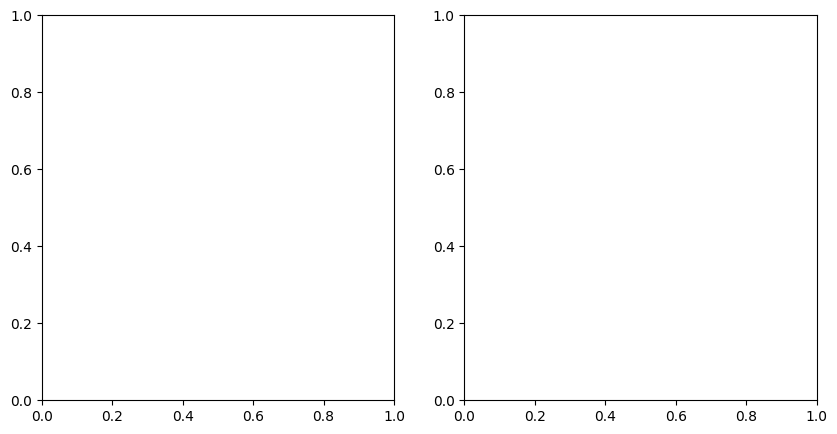

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from gradio_demo import load_datasets

hssayeni_dir = '/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/datasets/Hssayeni/'
synth_dir = Path('/scratch/brandon.nelson/demos/pediatric_ich_cadt/results2')

patients = load_datasets(hssayeni_dir, synth_dir)
patients

In [2]:
from gradio_demo import load_synthetic_data

synth = load_synthetic_data(synth_dir)
synth


,case_id,phantom,scanner_model,kVp,mA,pitch,views,scan_coverage,recon_kernel,slice_thickness,...,lesion_volume(mL),lesion_attenuation(HU),"lesion_location(z,y,x)",mask_file_path,Epidural,Intraparenchymal,No_Hemorrhage,Subdural,file,SliceNumber
0,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0
1,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,1
2,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,2
3,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,3
4,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,130
131,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,131
132,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,132
133,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,133


In [3]:
patients[(patients.Intraparenchymal == 1) & (patients.dataset == 'Synthetic')]

,name,age,dataset,SliceNumber,Epidural,Subdural,Intraparenchymal,Intraventricular,Subarachnoid,No_Hemorrhage,file
3712,synthetic 1,2.00,Synthetic,47.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
3713,synthetic 1,2.00,Synthetic,48.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
3714,synthetic 1,2.00,Synthetic,49.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
3715,synthetic 1,2.00,Synthetic,50.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
3716,synthetic 1,2.00,Synthetic,51.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
...,...,...,...,...,...,...,...,...,...,...,...
14446,synthetic 43,15.75,Synthetic,68.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14447,synthetic 43,15.75,Synthetic,69.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14448,synthetic 43,15.75,Synthetic,70.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14449,synthetic 43,15.75,Synthetic,71.0,0.0,0.0,1.0,0.0,0.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...


In [4]:
from gradio_demo import load_synthetic_data

synth = load_synthetic_data(synth_dir)
synth

,case_id,phantom,scanner_model,kVp,mA,pitch,views,scan_coverage,recon_kernel,slice_thickness,...,lesion_volume(mL),lesion_attenuation(HU),"lesion_location(z,y,x)",mask_file_path,Epidural,Intraparenchymal,No_Hemorrhage,Subdural,file,SliceNumber
0,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0
1,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,1
2,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,2
3,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,3
4,case_0024,6.5 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,130
131,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,131
132,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,132
133,case_0043,15.75 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.0,0.0,NaN,/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,1.0,0.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,133


In [5]:
synth_labels_to_real = {
    'EDH': 'Epidural',
    'SDH': 'Subdural',
    'IPH': 'Intraparenchymal',
    'IVH': 'Intraventricular',
    'SAH': 'Subarachnoid',
    None: 'No_Hemorrhage',
}
pd.get_dummies(synth.subtype.apply(lambda o: synth_labels_to_real.get(o, 'No_Hemorrhage')))

,Epidural,Intraparenchymal,No_Hemorrhage,Subdural
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
130,False,False,True,False
131,False,False,True,False
132,False,False,True,False
133,False,False,True,False


In [6]:
synth[synth.subtype == 'SDH']

,case_id,phantom,scanner_model,kVp,mA,pitch,views,scan_coverage,recon_kernel,slice_thickness,...,lesion_volume(mL),lesion_attenuation(HU),"lesion_location(z,y,x)",mask_file_path,Epidural,Intraparenchymal,No_Hemorrhage,Subdural,file,SliceNumber
53,case_0072,12.0 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.013113,-667.317017,"[53.0, 319.2, 380.7]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,53
54,case_0072,12.0 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.740528,-1356.984863,"[54.0, 339.5, 358.1], [54.0, 137.6, 153.7]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,54
55,case_0072,12.0 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.735998,-1320.061523,"[55.0, 339.1, 358.0], [55.0, 135.6, 157.7]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,55
56,case_0072,12.0 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.671148,-1321.986084,"[56.0, 337.0, 358.8], [56.0, 132.0, 168.4]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,56
57,case_0072,12.0 yr NIHPD Head,Siemens_DefinitionFlash,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.655890,-1325.969238,"[57.0, 337.2, 358.4], [57.0, 115.4, 187.2]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,case_0085,6.5 yr NIHPD Head,GE_Lightspeed64,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.068426,-816.697144,"[78.0, 149.9, 246.2]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,78
79,case_0085,6.5 yr NIHPD Head,GE_Lightspeed64,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.125647,-821.590759,"[79.0, 150.0, 256.8]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,79
80,case_0085,6.5 yr NIHPD Head,GE_Lightspeed64,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.135899,-826.430786,"[80.0, 148.8, 261.3]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,80
81,case_0085,6.5 yr NIHPD Head,GE_Lightspeed64,120.0,300.0,0.0,1000.0,dynamic,soft,1,...,0.102997,-831.324097,"[81.0, 147.3, 262.9]",/scratch/brandon.nelson/demos/pediatric_ich_ca...,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...,81


In [7]:
from gradio_demo import visualize_ict_pipeline
visualize_ict_pipeline('Patient synthetic 21', 86)

KeyboardInterrupt: 

In [ ]:
34 // 2

17

In [ ]:
patient_77 = patients[(patients['name'] == 77) & (patients['dataset'] == 'Hssayeni')]
patient_77.SliceNumber.max()

np.float64(35.0)

In [ ]:
import SimpleITK as sitk
vol = sitk.GetArrayFromImage(sitk.ReadImage(sorted(list(Path(patients[patients.name == 'synthetic 43']['file'].iloc[0]).glob('*.dcm')))))
vol.shape

(135, 512, 512)

# CAD module

In [ ]:
from model_utils import InferenceManager

In [ ]:
from model_utils import download_and_unzip
from dotenv import load_dotenv
import os
load_dotenv()

model_path = Path(os.environ['MODEL_PATH'])
if not model_path.exists():
    download_and_unzip('https://zenodo.org/records/15750437/files/model_files.zip', extract_to=model_path.parents[1]) 

In [ ]:
models = {m.parts[-2]: m for m in sorted(list(model_path.rglob('*.pth')))}
models

{'CAD_1': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_1/resnext101_32x8d_wsl_checkpoint.pth'),
 'CAD_2': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_2/resnext101_32x8d_wsl_checkpoint.pth'),
 'CAD_3': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_3/resnext101_32x8d_wsl_checkpoint.pth')}

In [ ]:
patients

,name,age,dataset,SliceNumber,Epidural,Subdural,Intraparenchymal,Intraventricular,Subarachnoid,No_Hemorrhage,file
0,49.0,35.00,Hssayeni,1.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
1,49.0,35.00,Hssayeni,2.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
2,49.0,35.00,Hssayeni,3.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
3,49.0,35.00,Hssayeni,4.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
4,49.0,35.00,Hssayeni,5.0,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
...,...,...,...,...,...,...,...,...,...,...,...
14508,synthetic 43,15.75,Synthetic,130.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14509,synthetic 43,15.75,Synthetic,131.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14510,synthetic 43,15.75,Synthetic,132.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
14511,synthetic 43,15.75,Synthetic,133.0,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...


In [ ]:
manager = InferenceManager(models['CAD_1'])
manager

In [ ]:
import nibabel as nib

# labels for the model output

patient = patients.iloc[0]
images = nib.load(patient['file']).get_fdata().transpose(2, 1, 0)[:, ::-1]
images.shape

(39, 512, 512)

In [ ]:
manager.load_patient(images)

In [ ]:
manager.get_slice_prediction(1)

{'Epidural': np.float32(3.5887854e-07),
 'Intraparenchymal': np.float32(3.0208156e-07),
 'Intraventricular': np.float32(1.824583e-10),
 'Subarachnoid': np.float32(5.296515e-08),
 'Subdural': np.float32(4.1862382e-08),
 'Any': np.float32(6.716469e-07)}

{'verbose': True}
Starting classification
Evaluating embeddings
slice 0: 0.5830855


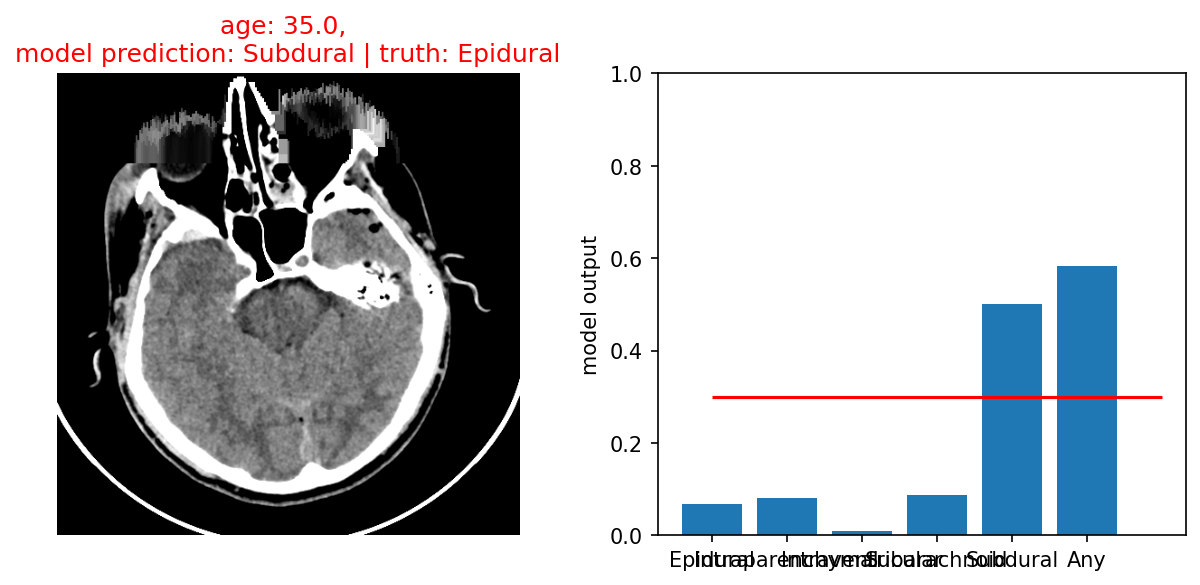

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from model_utils import predict_image

import albumentations as A
import torch
import nibabel as nib

# labels for the model output

patient = patients.iloc[0]
images = nib.load(patient['file']).get_fdata().transpose(2, 1, 0)[:, ::-1]
name = patient['name']
age = patient['age']

def ict_pipeline(slice_num, width=5, model_name='CAD_1'):

    image = np.mean(images[slice_num:slice_num+width], axis=0) # create average
    out = predict_image(image, models[model_name], device='cuda')
    return image, out



def visualize_ict_pipeline(slice_num, width=5, thresh=0.3, model_name='CAD_1', show=True):
    diagnosis = pd.read_csv(Path(hssayeni_dir) / 'hemorrhage_diagnosis_raw_ct.csv')
    label = diagnosis.loc[(diagnosis.PatientNumber == name) & (diagnosis.SliceNumber == slice_num + 1)].to_numpy()[:, 2:-1]
    cols = diagnosis.columns[2:-1]
    subtype = cols[label.argmax()]

    image, out = ict_pipeline(slice_num, width, model_name)

    f, axs = plt.subplots(1, 2, figsize = (10, 4), dpi=150)
    axs[0].imshow(image, vmin=0, vmax=80, cmap='gray')
    axs[0].set_axis_off()
    axs[1].bar(out.keys(), out.values())
    axs[1].set_ylabel('model output')
    axs[1].set_ylim([0, 1])
    axs[1].hlines(thresh, 0, len(out), colors='red')
    out.pop('Any')
    max_label = [k for k, v in out.items() if v == max(out.values())][0]
    predicted_label = max_label if out[max_label] > thresh else 'No_Hemorrhage'
    color = 'green' if predicted_label == subtype else 'red'
    axs[0].set_title(f'age: {age}, \nmodel prediction: {predicted_label} | truth: {subtype}', color=color)
    fname = Path('results.png').absolute()
    if show:
        plt.show()
        return None
    else:
        plt.savefig(fname)
        return fname

start = 13
thresh = 0.3
visualize_ict_pipeline(start, width=1, thresh=0.3, model_name='CAD_1')

In [ ]:
image, out = ict_pipeline(13, width=3, model_name='CAD_1')
out

{'verbose': True}
Starting classification


Evaluating embeddings
slice 0: 0.68161607


{'Epidural': np.float32(0.23167278),
 'Intraparenchymal': np.float32(0.14654328),
 'Intraventricular': np.float32(0.013275686),
 'Subarachnoid': np.float32(0.12555647),
 'Subdural': np.float32(0.41788357),
 'Any': np.float32(0.68161607)}

Loading datasets...
Processing dataset: Hssayeni


Evaluating Hssayeni: 100%|██████████| 75/75 [21:44<00:00, 17.39s/it]


Processing dataset: Synthetic


Evaluating Synthetic: 100%|██████████| 92/92 [1:56:37<00:00, 76.06s/it]



AUC Scores:
      Dataset    Level  Model              Type       AUC
0    Hssayeni    Slice  CAD_1               Any  0.975198
1    Hssayeni    Slice  CAD_2               Any  0.953798
2    Hssayeni    Slice  CAD_3               Any  0.954020
3    Hssayeni    Slice  CAD_1          Epidural  0.946121
4    Hssayeni    Slice  CAD_2          Epidural  0.912785
5    Hssayeni    Slice  CAD_3          Epidural  0.887985
6    Hssayeni    Slice  CAD_1          Subdural  0.985950
7    Hssayeni    Slice  CAD_2          Subdural  0.948643
8    Hssayeni    Slice  CAD_3          Subdural  0.959734
9    Hssayeni    Slice  CAD_1  Intraparenchymal  0.974202
10   Hssayeni    Slice  CAD_2  Intraparenchymal  0.969134
11   Hssayeni    Slice  CAD_3  Intraparenchymal  0.976746
12   Hssayeni    Slice  CAD_1  Intraventricular  0.995027
13   Hssayeni    Slice  CAD_2  Intraventricular  0.994967
14   Hssayeni    Slice  CAD_3  Intraventricular  0.993041
15   Hssayeni    Slice  CAD_1      Subarachnoid  0.970394
1

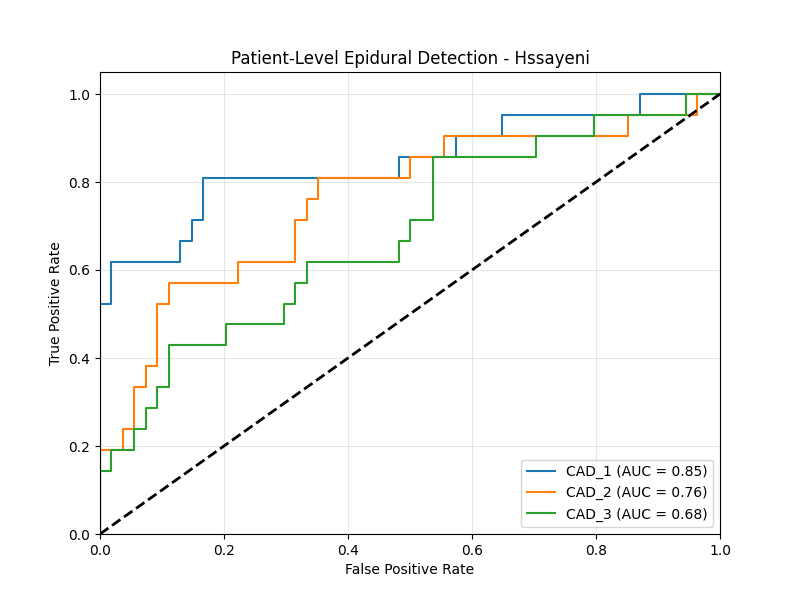

Displaying Hssayeni_Patient_Intraparenchymal_ROC.png


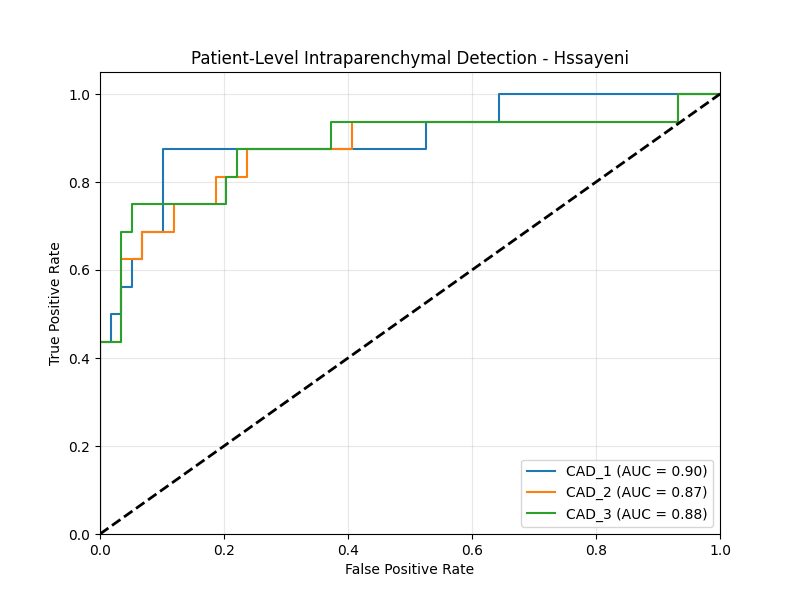

Displaying Hssayeni_Patient_Intraventricular_ROC.png


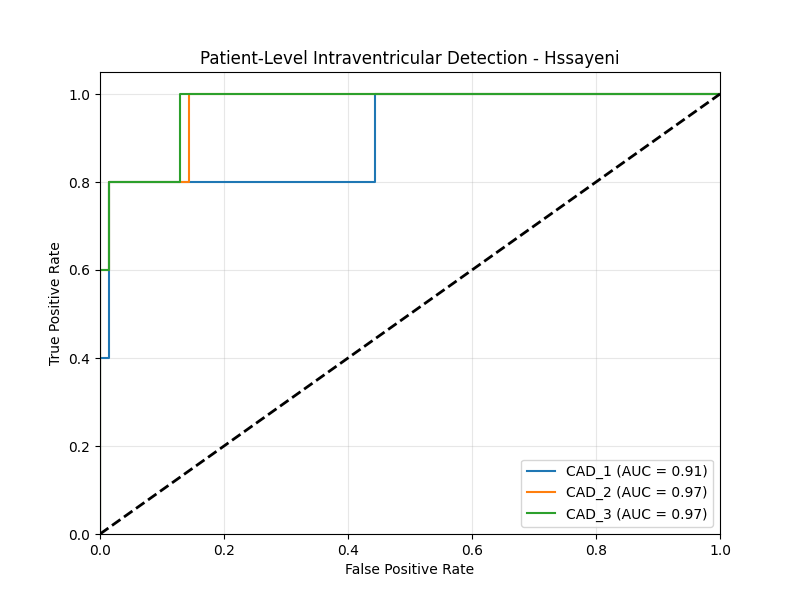

Displaying Hssayeni_Patient_Overall_ROC.png


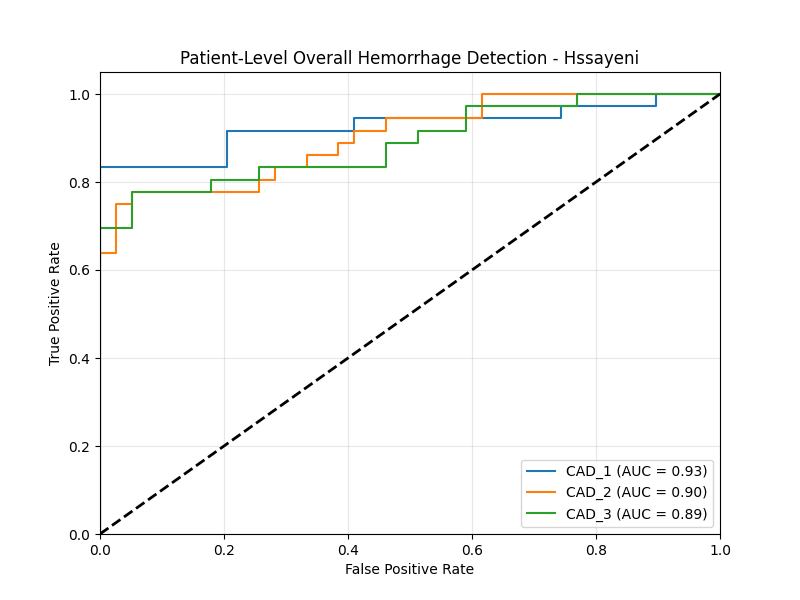

Displaying Hssayeni_Patient_Subarachnoid_ROC.png


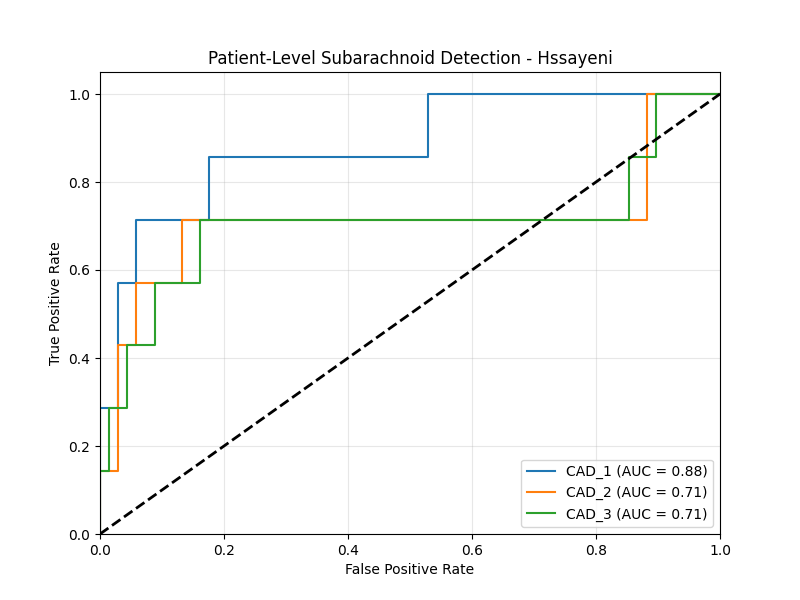

Displaying Hssayeni_Patient_Subdural_ROC.png


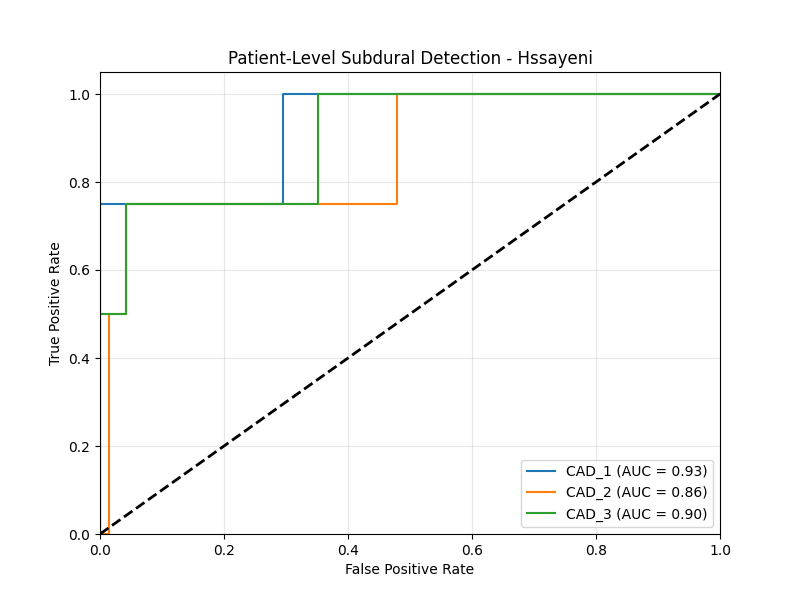

Displaying Hssayeni_Slice_Epidural_ROC.png


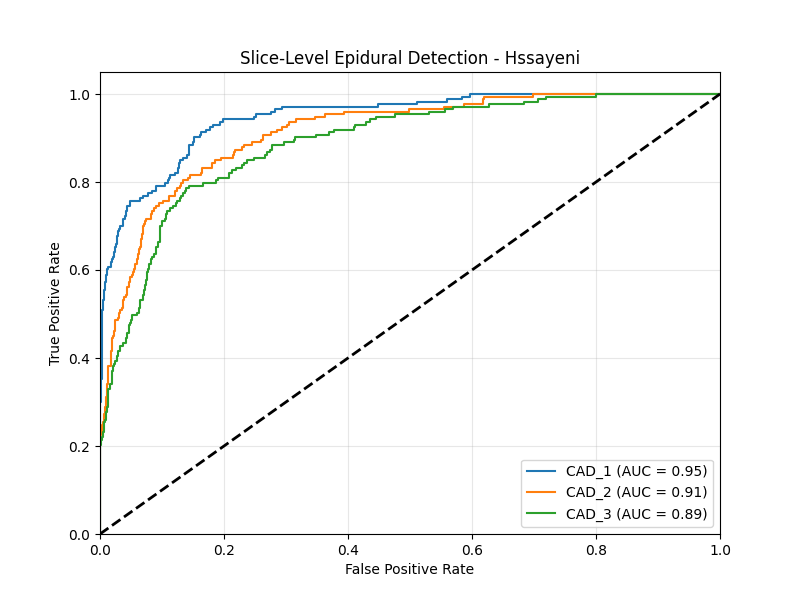

Displaying Hssayeni_Slice_Intraparenchymal_ROC.png


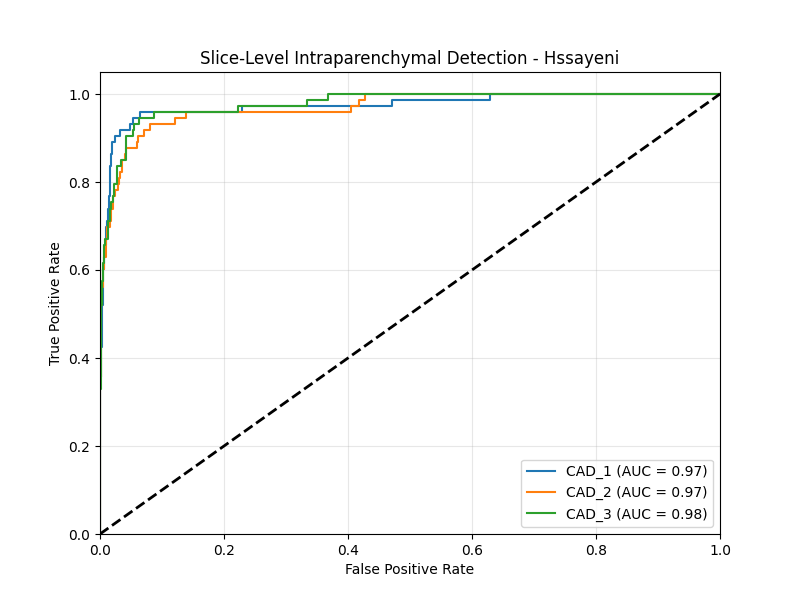

Displaying Hssayeni_Slice_Intraventricular_ROC.png


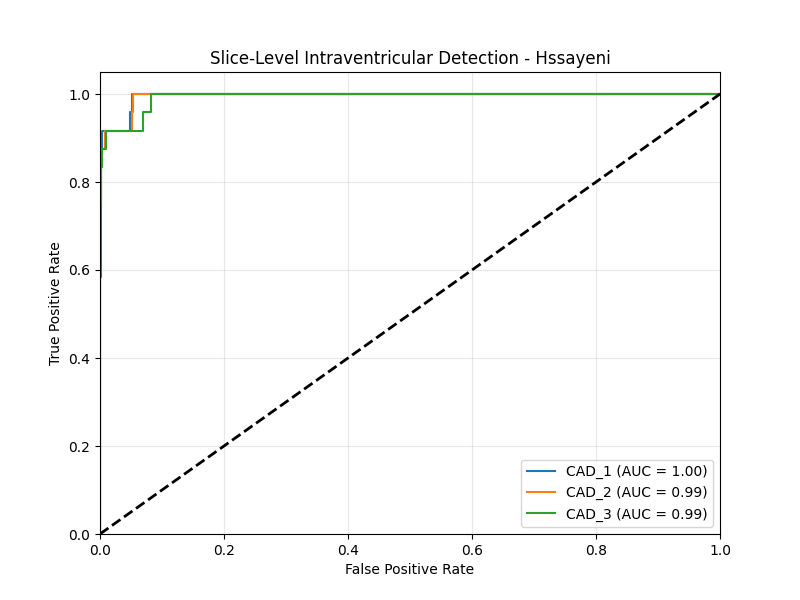

Displaying Hssayeni_Slice_Overall_ROC.png


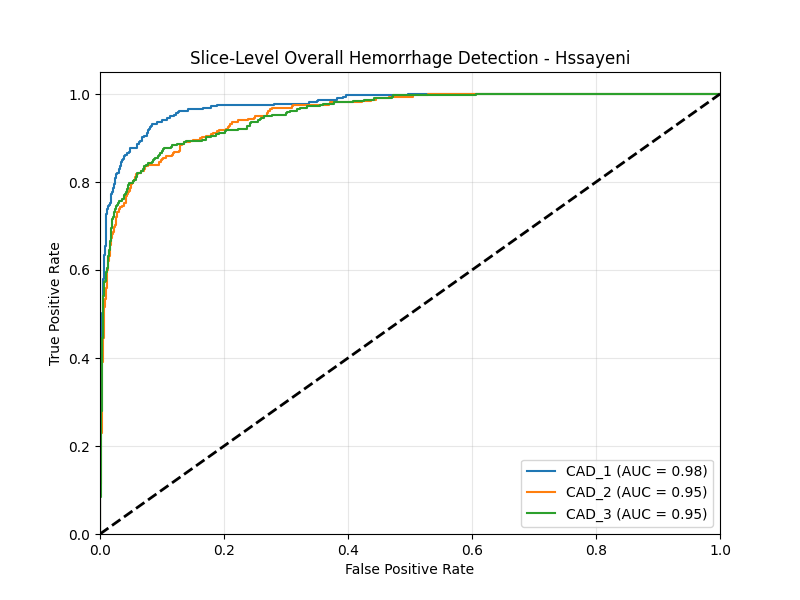

Displaying Hssayeni_Slice_Subarachnoid_ROC.png


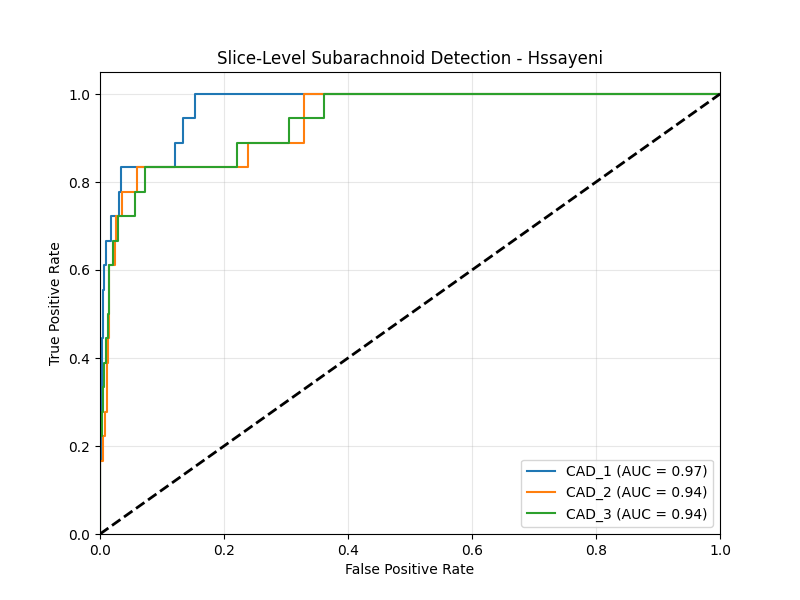

Displaying Hssayeni_Slice_Subdural_ROC.png


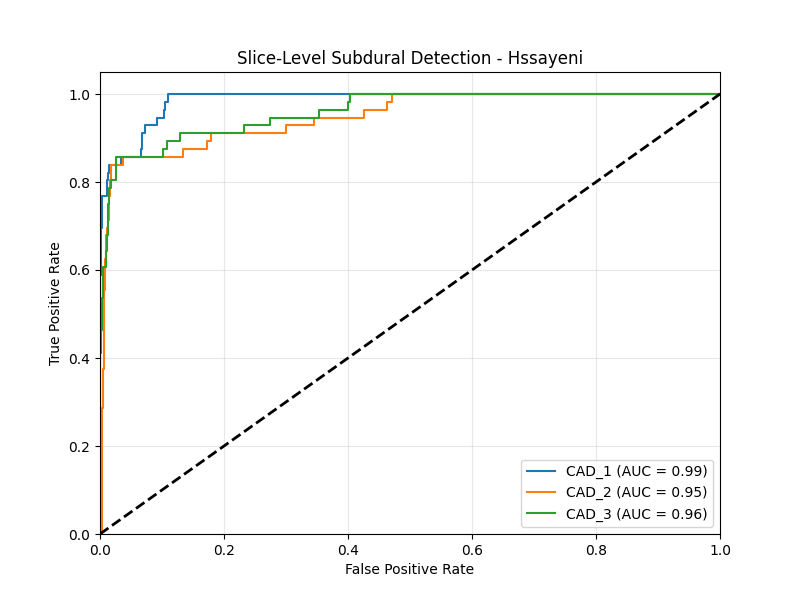

Displaying Synthetic_Patient_Epidural_ROC.png


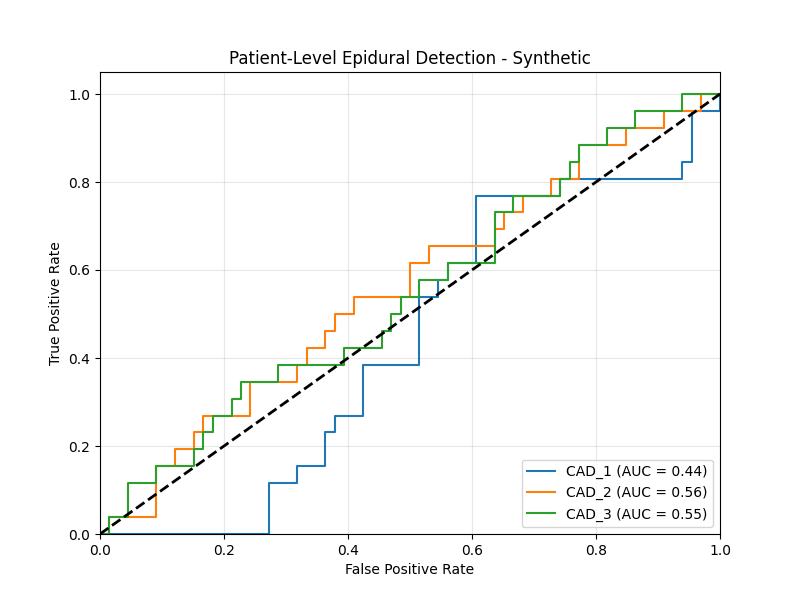

Displaying Synthetic_Patient_Intraparenchymal_ROC.png


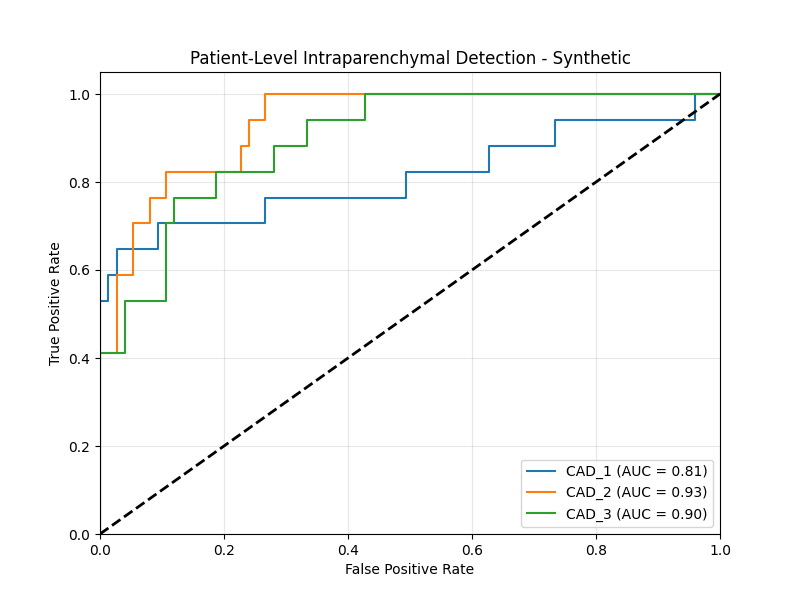

Displaying Synthetic_Patient_Overall_ROC.png


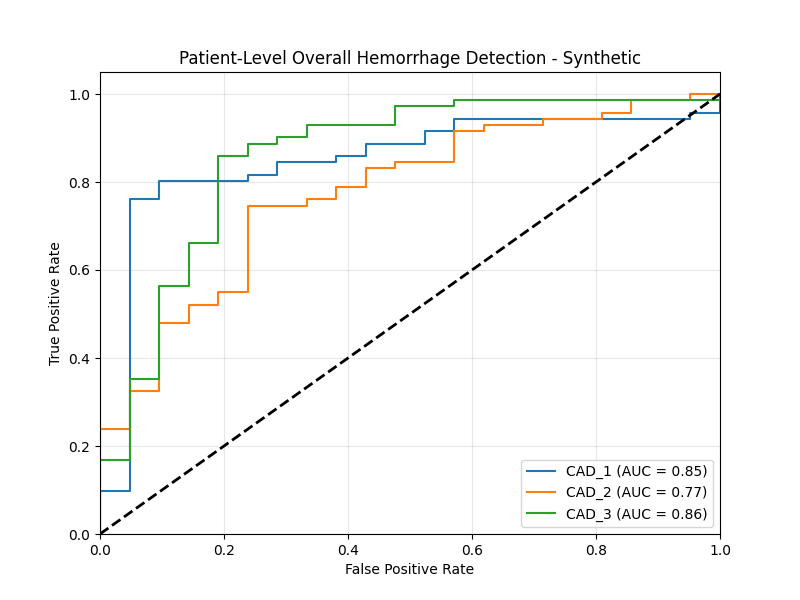

Displaying Synthetic_Patient_Subdural_ROC.png


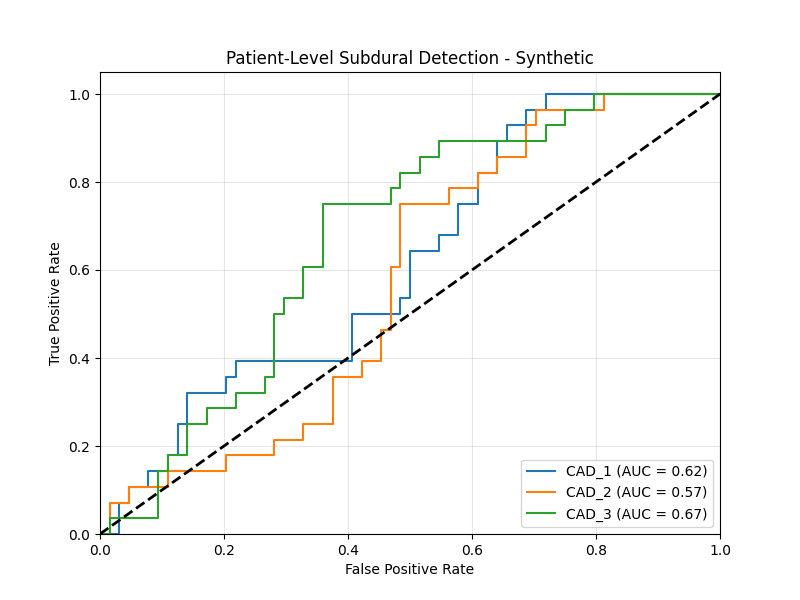

Displaying Synthetic_Slice_Epidural_ROC.png


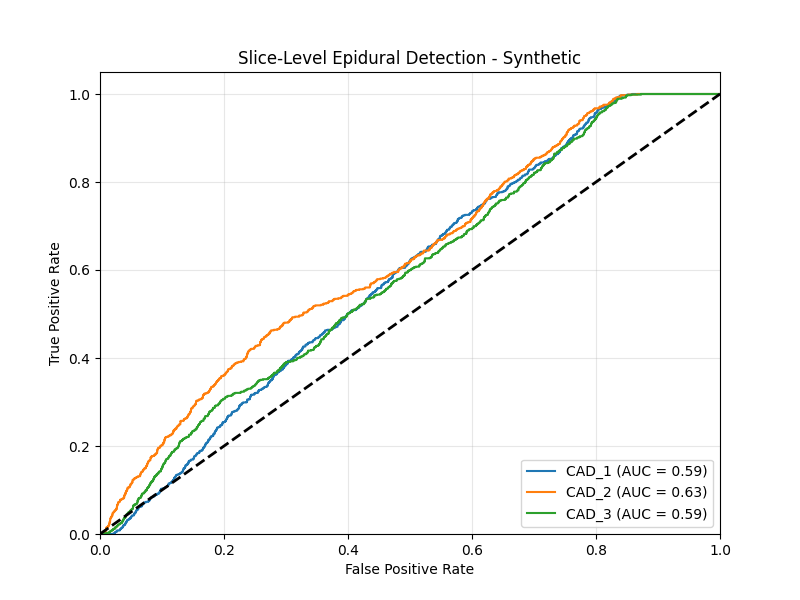

Displaying Synthetic_Slice_Intraparenchymal_ROC.png


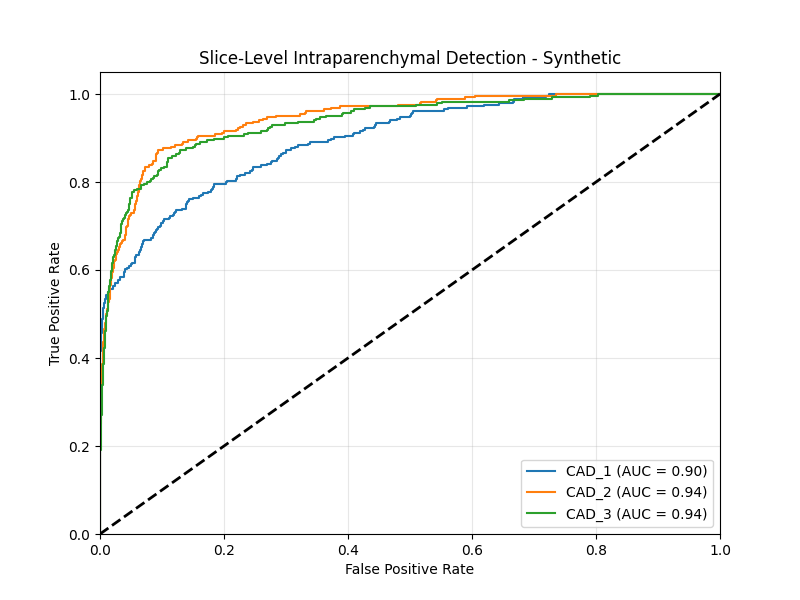

Displaying Synthetic_Slice_Overall_ROC.png


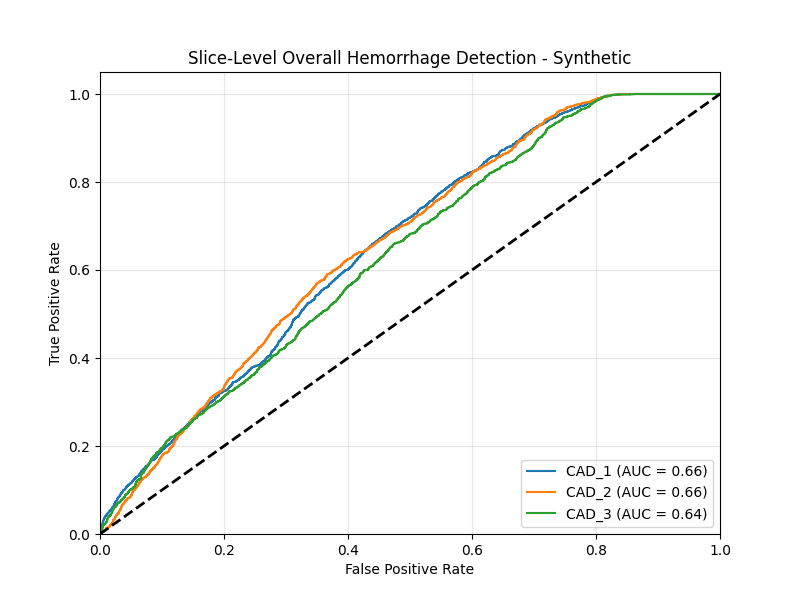

Displaying Synthetic_Slice_Subdural_ROC.png


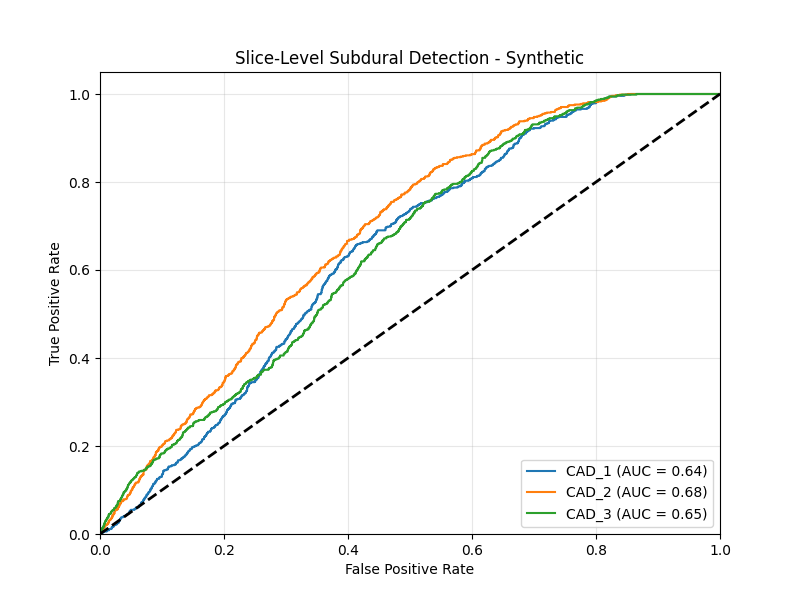

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
from roc_analysis import main as run_roc_analysis
from IPython.display import Image, display
from pathlib import Path
import os

run_roc_analysis()

output_dir = 'results'
if os.path.exists(output_dir):
    for image_file in sorted(Path(output_dir).glob('*.png')):
        print(f"Displaying {image_file.name}")
        display(Image(filename=str(image_file)))